In [1]:
%matplotlib inline

import matplotlib.colors
import numpy as np
import pandas as pd
import power_laws
import rubisco_data
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Categories used to color enzymes by the physiology of their host organisms. Purpose
# of this is to highlight the steroetyped variation in SC/O. 

# Note: it's challenging to come up with a uniform taxonomy for autotrophs because the
# important physiological characteristics (e.g. C4, CAM, carboxysome CCMs) are polyphyletic.
# The ad-hoc taxonomy in our supplementary file could probably be improved. However, for
# the purposes of this work, we "lump" together some of the groups for which there is
# limited data - groups like heterokonts and haptophytes, which are phylogenetically disparate
# algae for which we have limited Rubisco data. 

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'Other Form I',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Gymnosperm': 'Other Form I',
                 'Basal angiosperm': 'Other Form I',
                 'Carnivorous plants': 'Other Form I',
                 'Bryophyte': 'Other Form I',
                 'CAM plants': 'Other Form I',
                 'Green algae': 'Other Form I',
                 'Diatoms': 'Other Form I',
                 'Chromophyte algae': 'Other Form I',
                 'Haptophyte algae': 'Other Form I',
                 'Rhodophyte algae': 'Other Form I',
                 'Macroalgae': 'Other Form I',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Other Form I',
                 'Betaproteobacteria': 'Other Form I',
                 'Gammaproteobacteria': 'Other Form I',
                }
color_mapping = {
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'C3 plants': 'dusty green',
    'Other plants': 'grey/green',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Diatoms': 'gunmetal',
    'Other algae': 'muddy brown',
    'Proteobacterial FI': 'dusty rose',
    'Other Form I': 'grey',
}
fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

# Order of plotting sets order of legend.
plotting_order = ['C3 plants', 'C4 plants', 'Red algae', 'Cyanobacteria', 'Other Form I']
# These groups have enough data for histograms to be plotted.
hist_groups = ['C4 plants', 'C3 plants', 'Cyanobacteria', 'Red algae', ]

In [4]:
# Panel A examines the central correlation of Tcherkez2006: kcat,C vs SC/O. 
# This cell reports correlations for this pair.

# kcat,C vs S - whole dataset
vCs = np.log(merged_kin_df.vC)
Ss = np.log(merged_kin_df.S)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))
print()

vCs = np.log(F1_data.vC)
Ss = np.log(F1_data.S)

print('FI subset')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))
print()

vCs = np.log(savir_df.vC)
Ss = np.log(savir_df.S)

print('Savir subset')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.03, P = 0.7
Spearman rank correlation R = -0.32, P = 1.7e-06

FI subset
Log-scale linear regression R = -0.56, P = 5.5e-19
Spearman rank correlation R = -0.38, P = 1.3e-08

Savir subset
Log-scale linear regression R = -0.71, P = 0.00072
Spearman rank correlation R = -0.88, P = 4.8e-07


In [5]:
# Naive fit of the FI subset of the dataset.
# kcat,C vs S correlation for all data rubiscos
Ss = np.log(F1_data.S)
vCs = np.log(F1_data.vC)
exponent, prefactor, r = power_laws.fit_power_law_odr(Ss, vCs)

# kcat,C vs S correlation for all data rubiscos
Ss_savir = np.log(savir_df.S)
vCs_savir = np.log(savir_df.vC)
exp_sav, pre_sav, r_sav = power_laws.fit_power_law_odr(Ss_savir, vCs_savir)

Bootstrapping FI fits
95% CI for log-scale Pearson R (-0.69, -0.38)
95% CI for power law exponent (-3.97, -1.99)
95% CI on power law prefactor (2.8e+04, 2.1e+08)


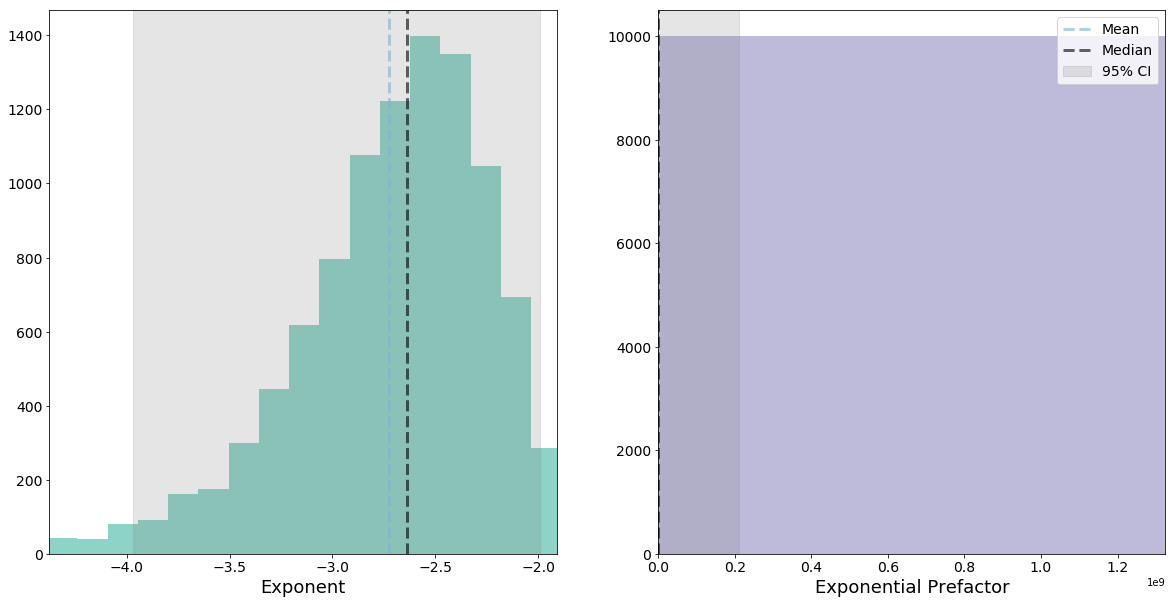

In [6]:
# Bootstrapped TLS fitting of kcat,C vs SC/O over the Form I data to calculate 95% CIs.
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    F1_data.S, F1_data.vC, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]  # middle 95%
pre_low, pre_high = np.percentile(pres, conf_range)
exp_low, exp_high = np.percentile(exps, conf_range)
r_low, r_high = np.percentile(rs, conf_range)

print('Bootstrapping FI fits')
print('95%% CI for log-scale Pearson R (%.2f, %.2f)' % (r_low, r_high))
print('95%% CI for power law exponent (%.2f, %.2f)' % (exp_low, exp_high))
print('95%% CI on power law prefactor (%.2g, %.2g)' % (pre_low, pre_high))

# Uncomment to look at the distributions. 
power_laws.plot_bootstrapped_range(exps, pres)

/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


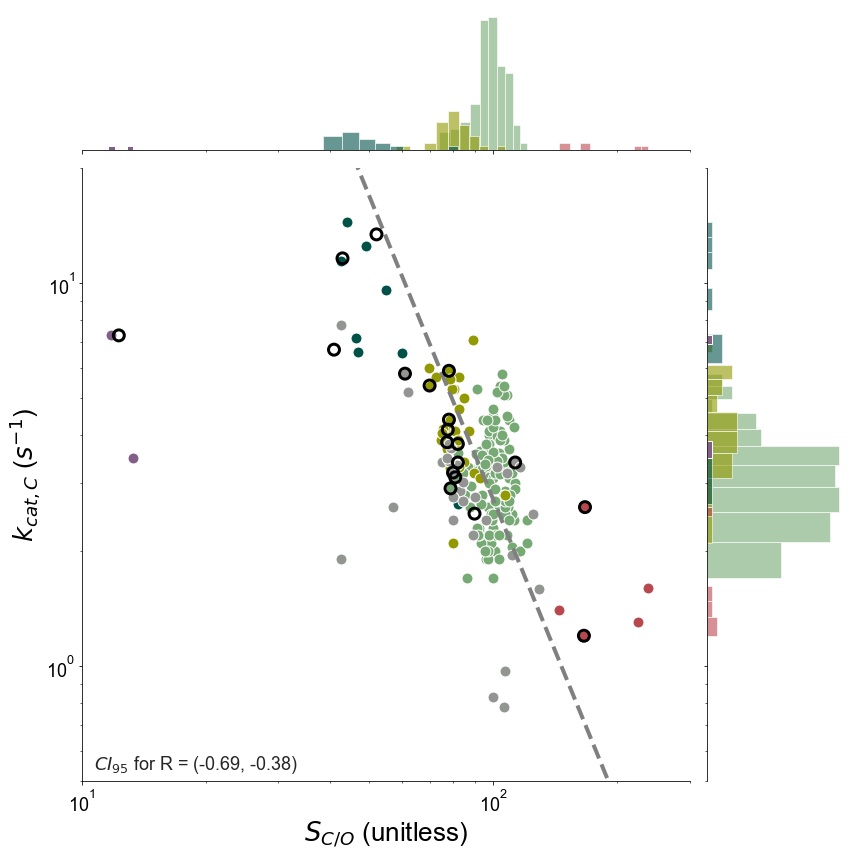

In [7]:
# Scatter plot of kcat,C vs SC/O colored by physiology, showing marginal distributions of 
# S and kcat,C on parallel axes.
g = sns.JointGrid('S', 'vC', data=merged_kin_df, height=12, ratio=4)
sns.set_style('white')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlim(10, 300)
g.ax_joint.set_ylim(5e-1, 20)

xvar, yvar = 'S', 'vC'

for group in plotting_order:
    gdf = grouped_taxa.get_group(group)

    cname = color_mapping.get(group, 'dark grey')
    c = sns.xkcd_rgb[cname]
    nx = gdf[xvar].notnull().sum()
    ny = gdf[yvar].notnull().sum()
    g.ax_joint.scatter(gdf[xvar], gdf[yvar], s=120, c=c, edgecolors='w', label=group)
    if group not in hist_groups:
        continue
    g.ax_marg_x.hist(gdf[xvar], color=c, alpha=0.6)
    g.ax_marg_y.hist(gdf[yvar], color=c, orientation='horizontal', alpha=0.6)

# Plot FII data separately.
f2_color = 'dusty purple'
c = sns.xkcd_rgb[f2_color]
g.ax_joint.scatter(F2_data.S, F2_data.vC, c=c, s=120, edgecolors='w', label='FII')
g.ax_marg_x.hist(F2_data.S, color=c)
g.ax_marg_y.hist(F2_data.vC, color=c, orientation='horizontal')

# Show savir data with an outline
g.ax_joint.scatter(savir_df.S, savir_df.vC, c='None', edgecolors='k', linewidths=3,
                   s=120, label='Savir 2010', zorder=10)

# Plot the naive fit of the FI data. 
xs = np.arange(10, 300, 1)
ys = np.power(xs, exponent)*prefactor
g.ax_joint.plot(xs, ys, color='grey', ls='--', lw=4)

g.ax_joint.set_xlabel('$S_{C/O}$ (unitless)', fontsize=26)
g.ax_joint.set_ylabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
g.ax_joint.tick_params(labelsize=18)
g.ax_joint.text(0.02, 0.02, '$CI_{95}$ for R = (%.2f, %.2f)' % (r_low, r_high), 
                transform=g.ax_joint.transAxes, fontsize=18)
#g.ax_joint.legend(ncol=2, loc=3, fontsize=16)
plt.tight_layout()

plt.savefig('fig5/fig5_kcatC_S_corr_FI.png', dpi=600)
plt.show()

In [8]:
# Savir 2010 focuses on kcat,C vs KC. Panel B investigates this 
vCs = np.log(merged_kin_df.vC)
KCs = np.log(merged_kin_df.KC)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))
print()

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
KCs = np.log(fIs.KC)

print('FI subset')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))
print()

vCs = np.log(savir_df.vC)
KCs = np.log(savir_df.KC)

print('Savir subset')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.35, P = 2e-08
Spearman rank correlation R = 0.44, P = 6.1e-13

FI subset
Log-scale linear regression R = 0.48, P = 3.4e-15
Spearman rank correlation R = 0.48, P = 3.2e-15

Savir subset
Log-scale linear regression R = 0.92, P = 2.9e-08
Spearman rank correlation R = 0.86, P = 2e-06


In [9]:
# Naive fit of the FI subset of the dataset.
# kcat,C vs KC correlation for all data rubiscos
KCs = np.log(F1_data.KC)
vCs = np.log(F1_data.vC)
exponent, prefactor, r = power_laws.fit_power_law_odr(KCs, vCs)

# kcat,C vs KC correlation for all data rubiscos
KCs_savir = np.log(savir_df.KC)
vCs_savir = np.log(savir_df.vC)
exp_sav, pre_sav, r_sav = power_laws.fit_power_law_odr(KCs_savir, vCs_savir)

Bootstrapping FI fits
95% CI for log-scale Pearson R (0.26, 0.66)
95% CI for power law exponent (0.25, 0.50)
95% CI on power law prefactor (0.80, 1.57)


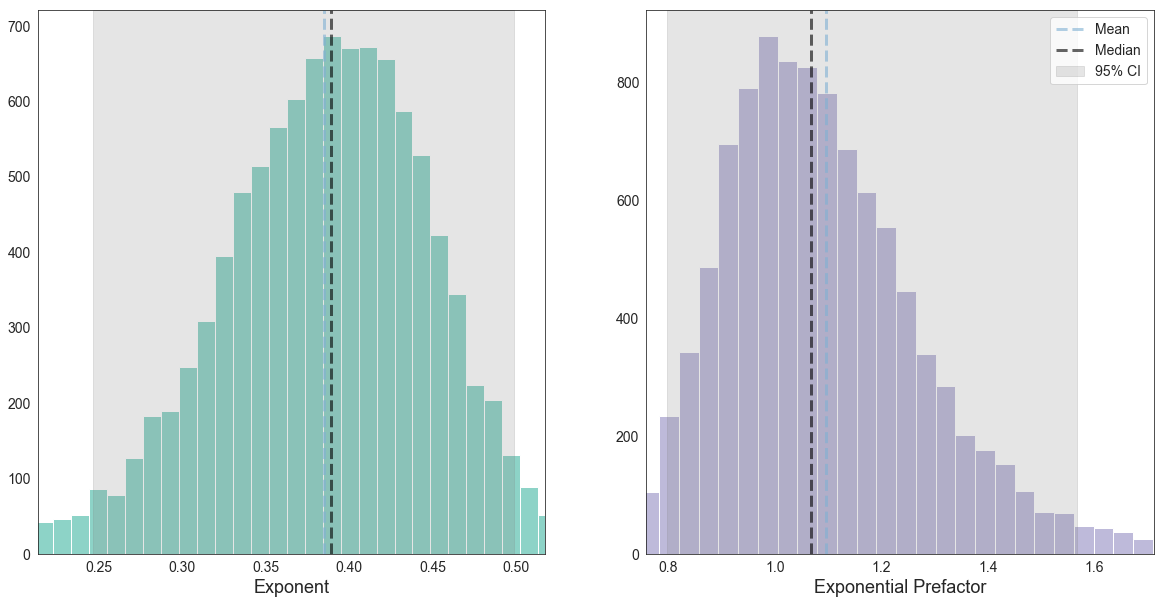

In [10]:
# Bootstrapped TLS fitting of kcat,C vs KC over the Form I data to calculate 95% CIs.
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    F1_data.KC, F1_data.vC, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]  # middle 95%
pre_low, pre_high = np.percentile(pres, conf_range)
exp_low, exp_high = np.percentile(exps, conf_range)
r_low, r_high = np.percentile(rs, conf_range)

print('Bootstrapping FI fits')
print('95%% CI for log-scale Pearson R (%.2f, %.2f)' % (r_low, r_high))
print('95%% CI for power law exponent (%.2f, %.2f)' % (exp_low, exp_high))
print('95%% CI on power law prefactor (%.2f, %.2f)' % (pre_low, pre_high))

# Uncomment to look at the distributions. 
power_laws.plot_bootstrapped_range(exps, pres)

/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


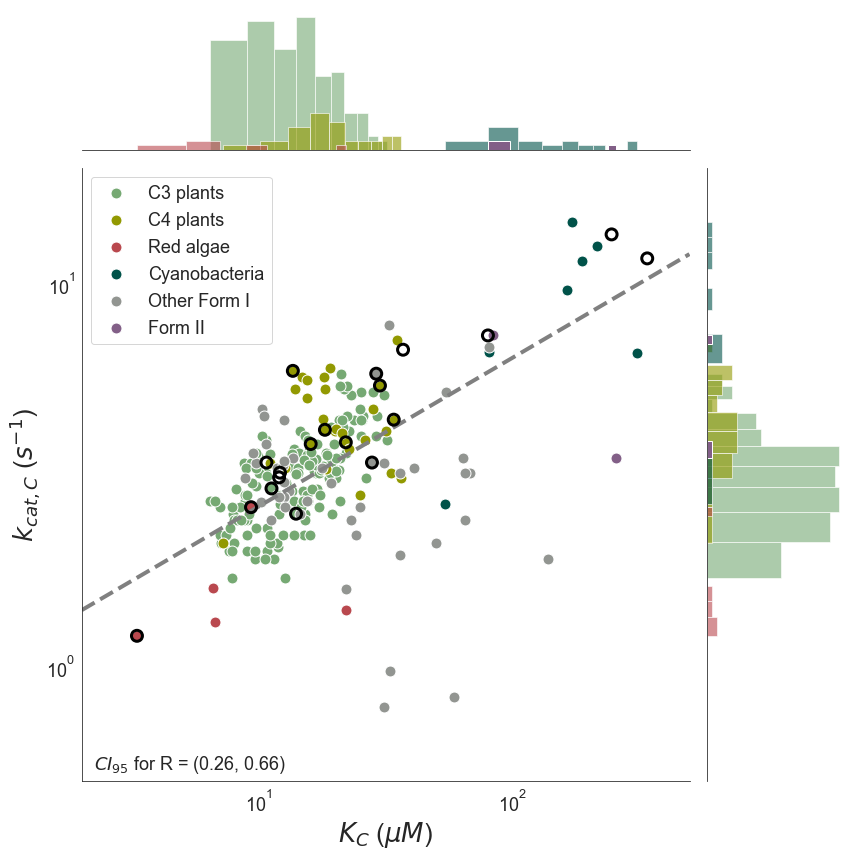

In [11]:
# Scatter plot of kcat,C vs KC colored by physiology, showing marginal distributions of 
# kcat,C and KC on parallel axes.

g = sns.JointGrid('S', 'vC', data=merged_kin_df, height=12, ratio=4)
sns.set_style('white')
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

g.ax_joint.set_xlim(2, 500)
g.ax_joint.set_ylim(5e-1, 20)

xvar, yvar = 'KC', 'vC'

for i, group in enumerate(plotting_order):
    gdf = grouped_taxa.get_group(group)

    cname = color_mapping.get(group, 'dark grey')
    c = sns.xkcd_rgb[cname]

    nx = gdf[xvar].notnull().sum()
    ny = gdf[yvar].notnull().sum()
    g.ax_joint.scatter(gdf[xvar], gdf[yvar], s=120, c=c, edgecolors='w', label=group)
    if group not in hist_groups:
        continue
    g.ax_marg_x.hist(gdf[xvar], color=c, alpha=0.6)
    g.ax_marg_y.hist(gdf[yvar], color=c, orientation='horizontal', alpha=0.6)

# Plot FII data separately.
f2_color = 'dusty purple'
c = sns.xkcd_rgb[f2_color]
g.ax_joint.scatter(F2_data.KC, F2_data.vC, c=c, s=120, edgecolors='w', label='Form II')
g.ax_marg_x.hist(F2_data.KC, color=c)
g.ax_marg_y.hist(F2_data.vC, color=c, orientation='horizontal')

# Show Savir data with an outline
g.ax_joint.scatter(savir_df.KC, savir_df.vC, c='None', edgecolors='k', linewidths=3,
                   s=120, label=None, zorder=10)

# Plot the naive fit of the FI data. 
xs = np.arange(2, 500, 1)
ys = np.power(xs, exponent)*prefactor
g.ax_joint.plot(xs, ys, color='grey', ls='--', lw=4)

g.ax_joint.set_xlabel('$K_{C}$ ($\mu M$)', fontsize=26)
g.ax_joint.set_ylabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
g.ax_joint.tick_params(labelsize=18)
g.ax_joint.text(0.02, 0.02, '$CI_{95}$ for R = (%.2f, %.2f)' % (r_low, r_high), 
                transform=g.ax_joint.transAxes, fontsize=18)
g.ax_joint.legend(ncol=1, loc=2, fontsize=18)
plt.tight_layout()

plt.savefig('fig5/fig5_kcatC_KC_corr_FI.png', dpi=600)
plt.show()

In [12]:
# Print summary statistics for SC/O, kcat,C and KC for all groups. 
params = 'S,vC,KC'.split(',')
for grp in plotting_order:
    gdf = grouped_taxa.get_group(grp)
    print(grp)
    for p in params:
        masked = gdf[p][gdf[p].notnull()]
        n = masked.size
        geomean = stats.gmean(masked)
        median = masked.median()
        sigma_star = power_laws.sigma_star(masked)
        print('%s (%d): median = %.2f, gmean = %.2g, sigma* = %.2f' % (
            p, n, geomean, median, sigma_star))
    print()

C3 plants
S (162): median = 98.25, gmean = 99, sigma* = 1.10
vC (150): median = 3.06, gmean = 3.2, sigma* = 1.30
KC (157): median = 13.98, gmean = 14, sigma* = 1.47

C4 plants
S (35): median = 80.42, gmean = 80, sigma* = 1.10
vC (30): median = 4.24, gmean = 4.1, sigma* = 1.30
KC (34): median = 20.08, gmean = 19, sigma* = 1.43

Red algae
S (6): median = 177.24, gmean = 1.7e+02, sigma* = 1.22
vC (5): median = 1.55, gmean = 1.4, sigma* = 1.32
KC (5): median = 7.85, gmean = 6.7, sigma* = 1.85

Cyanobacteria
S (16): median = 48.32, gmean = 47, sigma* = 1.20
vC (8): median = 7.97, gmean = 8.4, sigma* = 1.65
KC (16): median = 127.42, gmean = 1.2e+02, sigma* = 1.64

Other Form I
S (39): median = 81.03, gmean = 82, sigma* = 1.32
vC (45): median = 2.92, gmean = 3.2, sigma* = 1.57
KC (48): median = 23.45, gmean = 22, sigma* = 2.12



In [13]:
params = 'S,vC,KC'.split(',')

print('Form II')
for p in params:
    masked = F2_data[p][F2_data[p].notnull()]
    n = masked.size
    geomean = stats.gmean(masked)
    median = masked.median()
    sigma_star = power_laws.sigma_star(masked)
    print('%s (%d): median = %.2g, gmean = %.2g, sigma* = %.2f' % (
        p, n, geomean, median, sigma_star))
print()

Form II
S (3): median = 11, gmean = 12, sigma* = 1.18
vC (2): median = 5.1, gmean = 5.4, sigma* = 1.44
KC (3): median = 1.2e+02, gmean = 84, sigma* = 1.71

